In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

# Purpose: predict the duration of a ride

In [2]:
url_january = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
url_february = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"

In [3]:
df_january = pd.read_parquet(url_january)
df_february = pd.read_parquet(url_february)

In [4]:
df_january.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


# Q1. Downloading the data

Read the data for January. How many columns are there?

In [5]:
num_columns = df_january.shape[1]
num_columns

19

In [6]:
num_columns = len(df_january.columns)
num_columns

19

# Q2. Computing duration (Standard Deviation Jan)

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [7]:
df_january['duration'] = (pd.to_datetime(df_january['tpep_dropoff_datetime']) - pd.to_datetime(df_january['tpep_pickup_datetime'])).dt.total_seconds() / 60

In [8]:
df_january.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [9]:
std_duration = df_january['duration'].std()
std_duration

42.594351241920904

# Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [10]:
df_january['duration'] = (pd.to_datetime(df_january['tpep_dropoff_datetime']) - pd.to_datetime(df_january['tpep_pickup_datetime'])).dt.total_seconds() / 60

In [11]:
filtered_data = df_january[(df_january['duration'] >= 1) & (df_january['duration'] <= 60)]

In [12]:
fraction_left = len(filtered_data) / len(df_january)
fraction_left

0.9812202822125979

# Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

 it
What's the dimensionality of this matrix (number of columns)?

In [13]:
categorical = ['PULocationID', 'DOLocationID']

In [14]:
filtered_data[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [15]:
# Re-cast the IDs to strings
filtered_data.loc[:, categorical] = filtered_data[categorical].astype(str)

In [16]:
filtered_data[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [17]:
# Keep three columns
df_selected = filtered_data[categorical]
df_selected.head()

,PULocationID,DOLocationID
0,161,141
1,43,237
2,48,238
3,138,7
4,107,79


In [18]:
print(df_selected.shape)

(3009173, 2)


In [19]:
# Convert the dataframe to a list of dictionaries
train_dicts = df_selected.to_dict(orient='records')

In [20]:
# Initialize the dictionary vectorizer
dv = DictVectorizer()
# Fit the vectorizer and transform the data into a feature matrix
X_train = dv.fit_transform(train_dicts)

In [21]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [22]:
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [23]:
# Get the dimensionality of the feature matrix
num_columns = X_train.shape[1]
num_columns

515

# Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.
- 
Train a plain linear regression model with default parameter- s
Calculate the RMSE of the model on the training d
ata
What's the RMSE on train?

In [24]:
# Get the Y
target = 'duration'
y_train = filtered_data[target].values

In [32]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [25]:
# Train a plain linear regression model with default parameters
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
# Make predictions on the training data
predictions = lr.predict(X_train)

# Calculate the RMSE on the training data
rmse = np.sqrt(mean_squared_error(y_train, predictions, squared=False))
rmse

2.7657299092318994

/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


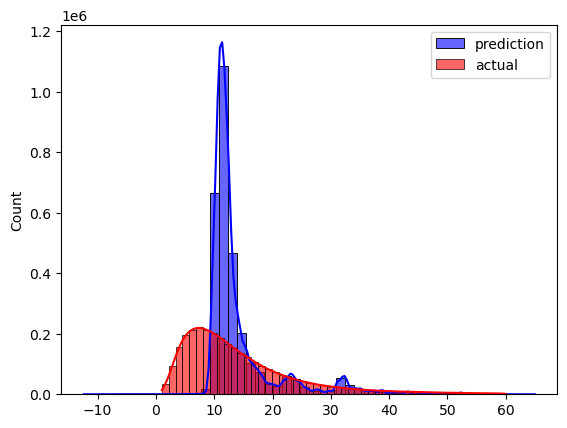

In [27]:
sns.histplot(predictions, kde=True, label='prediction', color='blue', alpha=0.6, bins=50)
sns.histplot(y_train, kde=True, label='actual', color='red', alpha=0.6, bins=50)

plt.legend()
plt.show()

# Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [28]:
# Calculate the duration in minutes
df_february['duration'] = (pd.to_datetime(df_february['tpep_dropoff_datetime']) - pd.to_datetime(df_february['tpep_pickup_datetime'])).dt.total_seconds() / 60

In [29]:
# Filter the data
filtered_data_february = df_february[(df_february['duration'] >= 1) & (df_february['duration'] <= 60)]

# Convert specified columns to string type using loc to avoid the SettingWithCopyWarning
filtered_data_february.loc[:, categorical] = filtered_data_february[categorical].astype(str)

# Keep only the relevant columns
df_selected_february = filtered_data_february[categorical]

In [30]:
# Convert the dataframe to a list of dictionaries
data_dict_february = df_selected_february.to_dict(orient='records')

# Transform the validation data using the already fitted dictionary vectorizer
X_val = dv.transform(data_dict_february)

In [31]:
# Target variable
y_val = filtered_data_february[target].values

# Make predictions on the validation data
predictions_val = lr.predict(X_val)

# Calculate the RMSE on the validation data
rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
print(f"The RMSE on the validation data is: {rmse_val:.2f}")

The RMSE on the validation data is: 7.81


/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


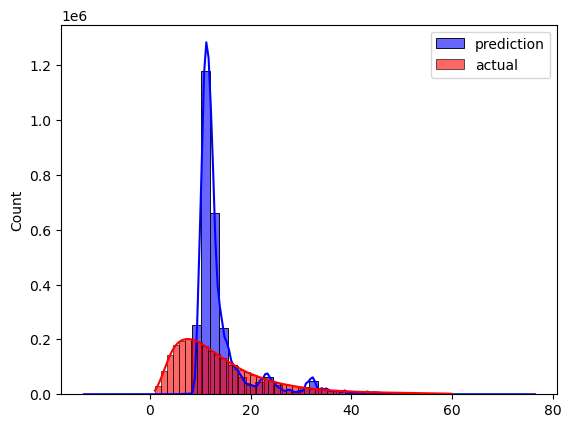

In [19]:
sns.histplot(predictions_val, kde=True, label='prediction', color='blue', alpha=0.6, bins=50)
sns.histplot(y_val, kde=True, label='actual', color='red', alpha=0.6, bins=50)

plt.legend()
plt.show()

# Restructuring the Code

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

    # Calculate the duration time
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

    # Filter out the outliers
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    # Convert the data types for features
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df  

In [6]:
url_january = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
url_february = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"

In [7]:
df_train = read_dataframe(url_january)
df_val = read_dataframe(url_february)

In [8]:
len(df_train), len(df_val)

(3009173, 2855951)

### Convert data into a feature matrix

In [10]:
categorical = ['PULocationID', 'DOLocationID']

In [11]:
# Initialize the dictionary vectorizer
dv = DictVectorizer()

# Convert the dataframe to a list of dictionaries
train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')
# Fit the vectorizer and transform the data into a feature matrix
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

### Train the model

In [12]:
# Get the Y
target = 'duration'
y_train = df_train[target].values

In [17]:
# Train a plain linear regression model with default parameters
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the training data
predictions = lr.predict(X_train)

# Calculate the RMSE on the training data
rmse = np.sqrt(mean_squared_error(y_train, predictions, squared=False))
print(f"The RMSE on the training data is: {rmse:.2f}")

The RMSE on the training data is: 2.77


### Validate the model

In [18]:
# Target variable
y_val = df_val[target].values

# Make predictions on the validation data
predictions_val = lr.predict(X_val)

# Calculate the RMSE on the validation data
rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
print(f"The RMSE on the validation data is: {rmse_val:.2f}")

The RMSE on the validation data is: 7.81
